<a href="https://colab.research.google.com/github/fabiobaroliveira/analises/blob/main/analise_exploratoria_frota_nacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Consulta e extração de informações sobre a frota nacional.

In [1]:
# Importando todas bibliotecas necessárias

import requests
import zipfile
import io
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# Carregando arquivo direto do site

# URL do arquivo .zip
url = 'https://dados.transportes.gov.br/dataset/12686da0-3d71-4499-b432-d270f785c907/resource/fc7e76f6-a46f-4c90-a952-2dc6d2bd8196/download/i_frota_por_uf_municipio_marca_e_modelo_ano_dezembro_2024.zip'

# Faz o download do arquivo com barra de progresso
print("Iniciando download do arquivo...")
response = requests.get(url, stream=True)  # stream=True para download em partes

# Verifica se o download foi bem-sucedido
if response.status_code == 200:
    # Obtém o tamanho total do arquivo (em bytes)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte

    # Cria um buffer para armazenar o conteúdo
    file_buffer = io.BytesIO()

    # Barra de progresso para o download
    with tqdm(total=total_size, unit='iB', unit_scale=True, desc="Download") as pbar:
        for data in response.iter_content(block_size):
            file_buffer.write(data)
            pbar.update(len(data))  # Atualiza a barra de progresso

    print("\nDownload concluído com sucesso!")

    # Prepara para extrair o arquivo
    file_buffer.seek(0)  # Volta ao início do buffer

    # Extrai o conteúdo do arquivo .zip com barra de progresso
    print("\nExtraindo arquivos...")
    with zipfile.ZipFile(file_buffer) as zip_file:
        # Obtém lista de arquivos para extração
        file_list = zip_file.infolist()

        # Barra de progresso para extração
        for file in tqdm(file_list, desc="Extraindo"):
            zip_file.extract(file, 'dados_extraidos')

    print("Extração concluída com sucesso!")

    # Renomeia o arquivo
    caminho_original = os.path.join('dados_extraidos', 'Layout I.TXT')
    novo_nome = os.path.join('dados_extraidos', 'base_de_dados.txt')

    if os.path.exists(caminho_original):
        os.rename(caminho_original, novo_nome)
        print(f"Arquivo renomeado para: {novo_nome}")
    else:
        print("Arquivo original não encontrado.")
else:
    print(f"Erro ao baixar o arquivo: {response.status_code}")

Iniciando download do arquivo...


Download: 100%|██████████| 128M/128M [03:09<00:00, 672kiB/s]



Download concluído com sucesso!

Extraindo arquivos...


Extraindo: 100%|██████████| 1/1 [00:09<00:00,  9.64s/it]

Extração concluída com sucesso!
Arquivo renomeado para: dados_extraidos/base_de_dados.txt


In [3]:
# Analisando o arquivo

# Caminho do arquivo
caminho_arquivo = os.path.join('dados_extraidos', 'base_de_dados.txt')

# Verifica se o arquivo existe
if os.path.exists(caminho_arquivo):
    print("Carregando o arquivo...")

    try:
        # Configuração do pandas para mostrar todas as colunas no info()
        pd.set_option('display.max_columns', None)

        # Carrega o arquivo em chunks (pedaços) para arquivos grandes
        chunks = pd.read_csv(caminho_arquivo,
                           encoding='utf-8',
                           delimiter=';',
                           chunksize=10000,
                           low_memory=False)

        # Concatena todos os chunks em um único DataFrame
        df = pd.concat(chunks)

        # Mostra apenas as informações do DataFrame
        print("\nInformações completas do DataFrame:")
        df.info(verbose=True, memory_usage='deep', show_counts=True)

    except Exception as e:
        print(f"\nErro ao ler o arquivo: {e}")
else:
    print("Arquivo não encontrado. Verifique o caminho.")

Carregando o arquivo...

Informações completas do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21105272 entries, 0 to 21105271
Data columns (total 5 columns):
 #   Column                      Non-Null Count     Dtype  
---  ------                      --------------     -----  
 0   UF                          21105272 non-null  object 
 1   Município                   21105272 non-null  object 
 2   Marca Modelo                21105272 non-null  object 
 3   Ano Fabricação Veículo CRV  21105272 non-null  object 
 4   Qtd. Veículos               21105272 non-null  float64
dtypes: float64(1), object(4)
memory usage: 5.5 GB


In [4]:
# Verificando as 10 primeiras linhas
display(df.head(10))

,UF,Município,Marca Modelo,Ano Fabricação Veículo CRV,Qtd. Veículos
0,ACRE,ACRELANDIA,AGRALE/13000,2009,1.0
1,ACRE,ACRELANDIA,AGRALE/1800,1989,1.0
2,ACRE,ACRELANDIA,AGRALE/1800,1990,1.0
3,ACRE,ACRELANDIA,AGRALE/1800D RD,1989,1.0
4,ACRE,ACRELANDIA,AGRALE/1800D RD,1990,2.0
5,ACRE,ACRELANDIA,AGRALE/1800D RD,1993,1.0
6,ACRE,ACRELANDIA,AGRALE/6000 D,2005,1.0
7,ACRE,ACRELANDIA,AGRALE/6000 D,2008,1.0
8,ACRE,ACRELANDIA,AGRALE/6000 D,2010,1.0
9,ACRE,ACRELANDIA,AGRALE/7000D RD,1994,1.0


In [7]:
# Analisando a coluna "Marca Modelo"

# Extrai os valores únicos da coluna "Marca Modelo"
valores_unicos = df['Marca Modelo'].unique()

# Mostra quantos valores diferentes existem
print(f"\nTotal de valores únicos: {len(valores_unicos)}")


Total de valores únicos: 37268


#Observação:

Devido há grande variedades de fabricantes e modelos se tem dificuldade em analisar esses dados é que ao longo dos anos fabricantes foram registrados de diferentes formas, como exemplo a fabricante alemã Mercedes-Benz, que teve registro como "M.BENZ", "MERCEDES BENZ" entre outros.



#Análises por Estado

In [8]:
# Criando o DataFrame consolidado por UF

df_veiculos_uf = (
    df.groupby('UF', as_index=False)['Qtd. Veículos']  # Agrupa por UF mantendo a coluna
    .sum()  # Soma a quantidade de veículos
    .astype({'Qtd. Veículos': int})  # Converte o numero para inteiro
    .sort_values('Qtd. Veículos', ascending=False)  # Ordena do maior para o menor
    .rename(columns={'Qtd. Veículos': 'Total de Veículos'})  # Renomeia a coluna
)

# Calculando o total geral
total_geral = df_veiculos_uf['Total de Veículos'].sum()

# Adicionando a coluna de porcentagem
df_veiculos_uf['Porcentagem do Total'] = (
    (df_veiculos_uf['Total de Veículos'] / total_geral * 100)
    .round(2)  # 2 casas decimais
)

# Visualizando o resultado
print("DataFrame consolidado por UF:")
display(df_veiculos_uf.head())  # Mostra as primeiras linhas

DataFrame consolidado por UF:


,UF,Total de Veículos,Porcentagem do Total
26,SAO PAULO,34332821,27.08
12,MINAS GERAIS,13975853,11.02
17,PARANA,9179768,7.24
22,RIO GRANDE DO SUL,8311600,6.56
20,RIO DE JANEIRO,7973983,6.29


In [9]:
# Criando novo arquivo .csv

df_veiculos_uf.to_csv('veiculos_por_uf.csv', index=False, sep=';')

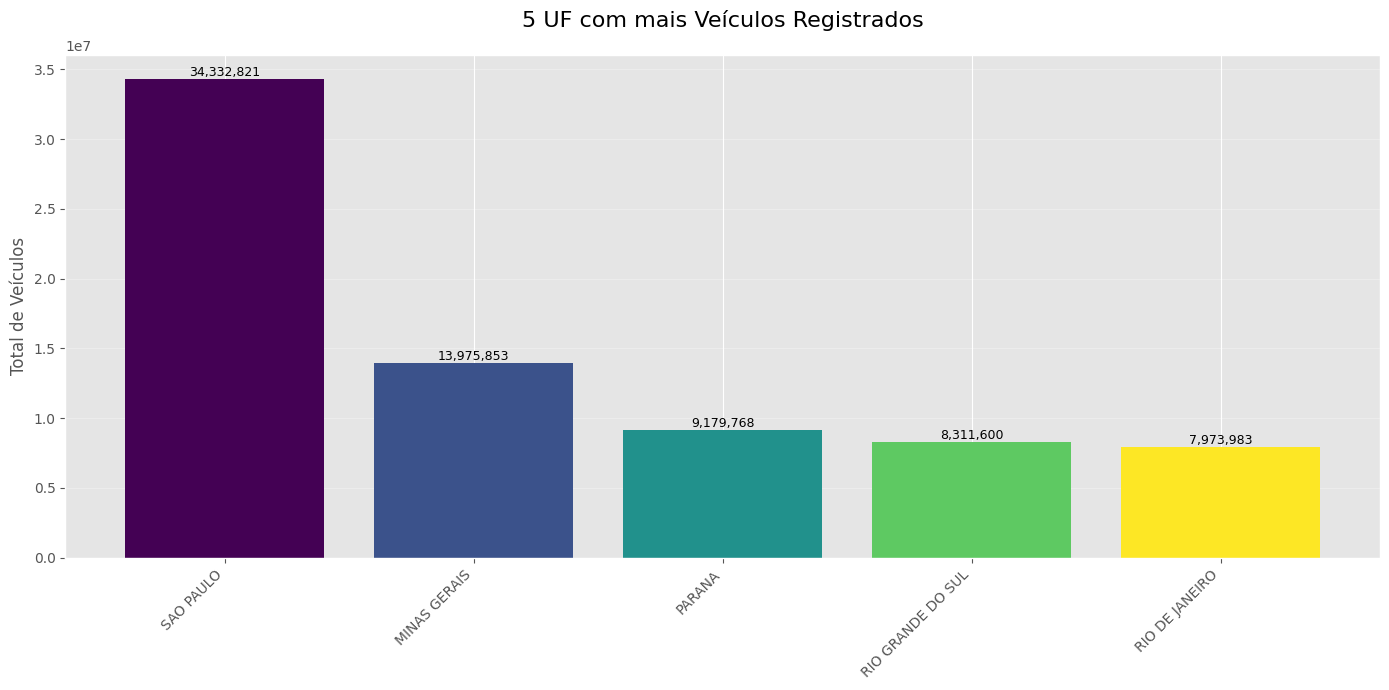

In [10]:
# Configurações de estilo
plt.style.use('ggplot')  # Usando um estilo válido
plt.figure(figsize=(14, 7))

top_5 = []

# Pegando os 5 maiores UF
top_5 = df_veiculos_uf.head(5)

# Criando o gráfico de barras
bars = plt.bar(
    top_5['UF'],
    top_5['Total de Veículos'],
    color=plt.cm.viridis(np.linspace(0, 1, len(top_5)))  # Gradiente de cores
)

# Adicionando valores nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}',
             ha='center', va='bottom', fontsize=9)

# Personalização do gráfico
plt.title('5 UF com mais Veículos Registrados', fontsize=16, pad=20)
plt.ylabel('Total de Veículos', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Extraindo informações por Ano de Fabricação

In [11]:
# Criando o DataFrame consolidado por Ano Fabricação Veículo CRV
df_veiculos_ano = (
    df.groupby('Ano Fabricação Veículo CRV', as_index=False)['Qtd. Veículos']  # Agrupa por "Ano Fabricação Veículo CRV" mantendo a coluna
    .sum()  # Soma a quantidade de veículos
    .astype({'Qtd. Veículos': int})  # Converte o numero para inteiro
    .sort_values('Qtd. Veículos', ascending=False)  # Ordena do maior para o menor
    .rename(columns={
        'Ano Fabricação Veículo CRV': 'Ano Fabricação',
        'Qtd. Veículos': 'Total de Veículos'})  # Renomeia as colunas
    .assign(
        Porcentagem=lambda x: (x['Total de Veículos'] / x['Total de Veículos'].sum() * 100).round(2)
    )
)

display(df_veiculos_ano.head(5))

,Ano Fabricação,Total de Veículos,Porcentagem
171,2011,6053396,4.77
173,2013,5611682,4.43
170,2010,5444334,4.29
172,2012,5429993,4.28
168,2008,5305395,4.18


In [12]:
# Criando novo arquivo .csv

df_veiculos_ano.to_csv('veiculos_por_ano.csv', index=False, sep=';')

In [13]:
# Criando o DataFrame consolidado por Ano Fabricação Veículo CRV (Últimos 20 anos)
df_veiculos_ano_20 = (
    df.groupby('Ano Fabricação Veículo CRV', as_index=False)['Qtd. Veículos']  # Agrupa por "Ano Fabricação Veículo CRV" mantendo a coluna
    .sum()  # Soma a quantidade de veículos
    .astype({'Qtd. Veículos': int})  # Converte o numero para inteiro
    .sort_values('Qtd. Veículos', ascending=False)  # Ordena do maior para o menor
    .rename(columns={
        'Ano Fabricação Veículo CRV': 'Ano Fabricação',
        'Qtd. Veículos': 'Total de Veículos'})  # Renomeia as colunas
    .assign(
        Porcentagem=lambda x: (x['Total de Veículos'] / x['Total de Veículos'].sum() * 100).round(2)
    )
)

display(df_veiculos_ano_20.head(5))

,Ano Fabricação,Total de Veículos,Porcentagem
171,2011,6053396,4.77
173,2013,5611682,4.43
170,2010,5444334,4.29
172,2012,5429993,4.28
168,2008,5305395,4.18


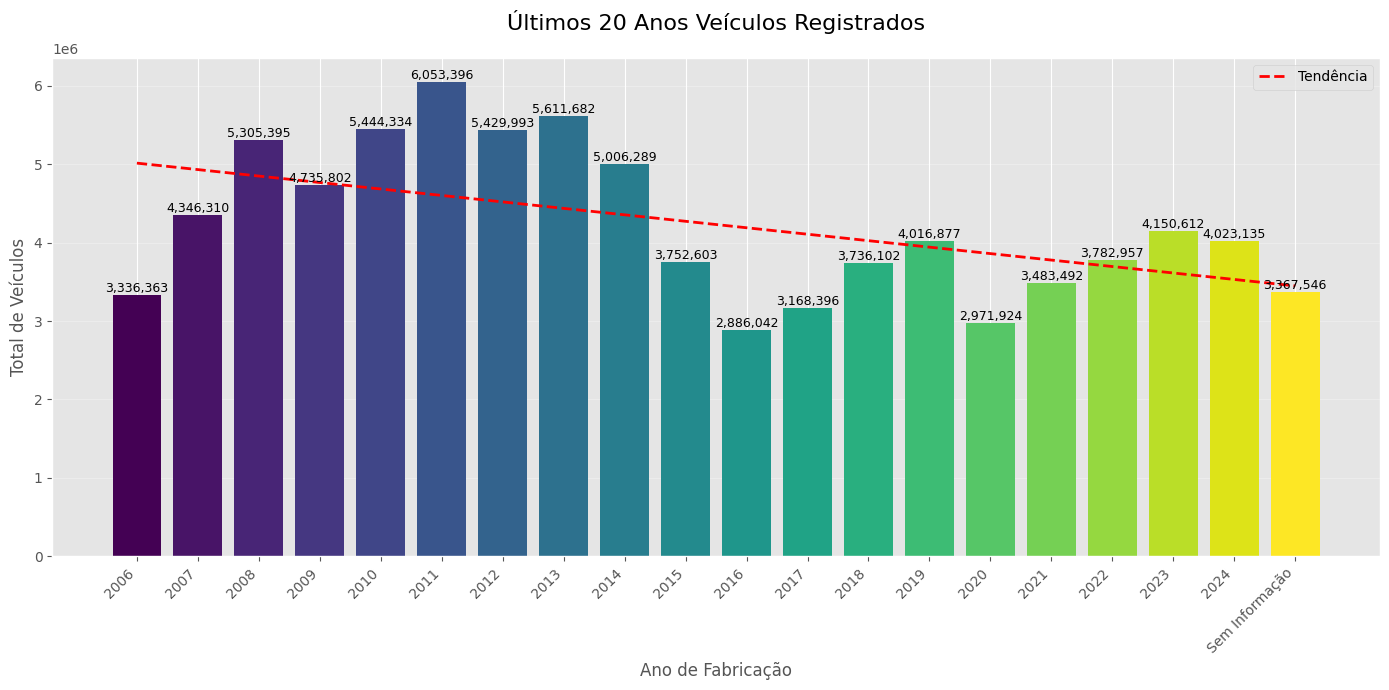

In [14]:
# Configurações de estilo
plt.style.use('ggplot')  # Usando um estilo válido
plt.figure(figsize=(14, 7))

# Pegando os últimos 20 anos
top_20 = df_veiculos_ano_20.head(20).sort_values('Ano Fabricação')

# Criando o gráfico de barras
bars = plt.bar(
    top_20['Ano Fabricação'].astype(str),
    top_20['Total de Veículos'],
    color=plt.cm.viridis(np.linspace(0, 1, len(top_20)))  # Gradiente de cores
)

# Adicionando valores nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}',
             ha='center', va='bottom', fontsize=9)

# Personalização do gráfico
plt.title('Últimos 20 Anos Veículos Registrados', fontsize=16, pad=20)
plt.xlabel('Ano de Fabricação', fontsize=12)
plt.ylabel('Total de Veículos', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Adicionando linha de tendência
x = range(len(top_20))
z = np.polyfit(x, top_20['Total de Veículos'], 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", linewidth=2, label='Tendência')

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#Analisando frota por UF e Ano Fabricação

In [15]:
# Criando um dicionário de DataFrames, um para cada UF

dfs_por_uf = {}

for uf in df['UF'].unique():
    dfs_por_uf[uf] = (
        df[df['UF'] == uf]  # Filtra apenas os dados da UF atual
        .groupby('Ano Fabricação Veículo CRV', as_index=False)['Qtd. Veículos']
        .sum()
        .astype({'Qtd. Veículos': int})
        .sort_values('Qtd. Veículos', ascending=False)
        .rename(columns={
            'Ano Fabricação Veículo CRV': 'Ano Fabricação',
            'Qtd. Veículos': 'Total de Veículos'
        })
        .assign(
            Porcentagem=lambda x: (x['Total de Veículos'] / x['Total de Veículos'].sum() * 100).round(2)
        )
    )


In [16]:
# Escolhendo a UF

escolha_estado = input("Digite o nome do estado sem acento (ex: SAO PAULO): ").upper()

if escolha_estado in dfs_por_uf:
    print(f"\nDataFrame para o estado {escolha_estado}:")
    display(dfs_por_uf[escolha_estado].head(5))
else:
    print(f"Estado '{escolha_estado}' não encontrado.")


Digite o nome do estado sem acento (ex: SAO PAULO): sao paulo

DataFrame para o estado SAO PAULO:


,Ano Fabricação,Total de Veículos,Porcentagem
111,2011,1531872,4.46
108,2008,1437930,4.19
110,2010,1400359,4.08
113,2013,1334671,3.89
112,2012,1321840,3.85


In [17]:
# Criando novo arquivo .csv

 # Criando o nome do arquivo
nome_arquivo = f"df_veiculos_uf_ano_{escolha_estado.lower().replace(' ', '_')}.csv"

    # Salvando como CSV
dfs_por_uf[escolha_estado].to_csv(nome_arquivo, index=False, sep=';', encoding='utf-8-sig')
print(f"\nArquivo salvo como: {nome_arquivo}")


Arquivo salvo como: df_veiculos_uf_ano_sao_paulo.csv


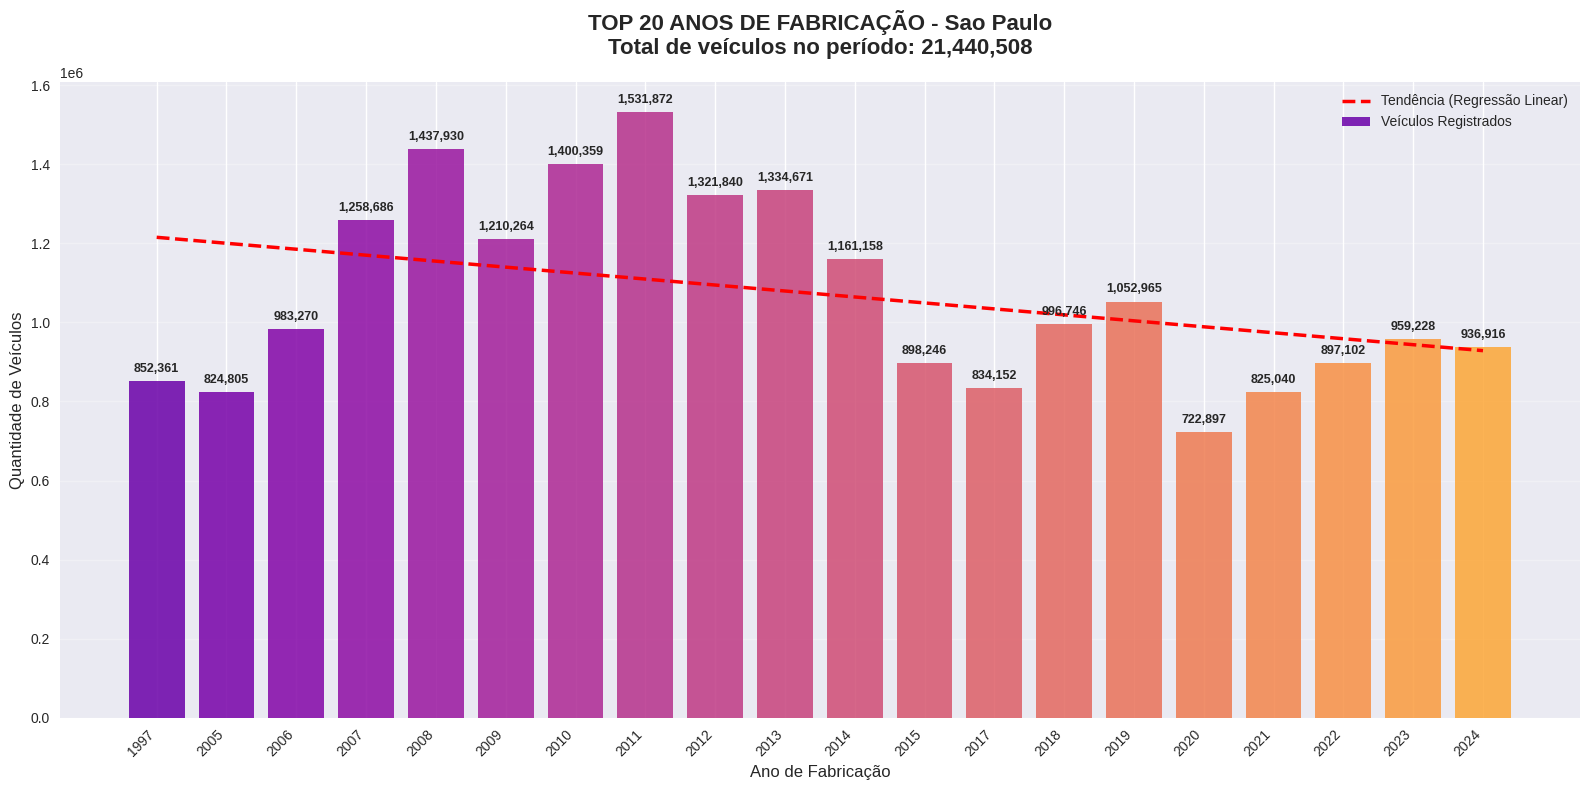

In [18]:
# Solicitar o estado ao usuário ou utilizar UF escolhida anteriormente

# escolha_estado = input("Digite o nome do estado sem acento (ex: SAO PAULO): ").upper()

if escolha_estado in dfs_por_uf:
    # Preparar os dados do estado (Top 20 anos)
    top_20_estado = (
        dfs_por_uf[escolha_estado]
        .sort_values('Total de Veículos', ascending=False)
        .head(20)
        .sort_values('Ano Fabricação')
    )

    # Configurações do gráfico
    plt.figure(figsize=(16, 8))
    plt.style.use('seaborn-v0_8')

    # --- GRÁFICO DE BARRAS ---
    bars = plt.bar(
        top_20_estado['Ano Fabricação'].astype(str),
        top_20_estado['Total de Veículos'],
        color=plt.cm.plasma(np.linspace(0.2, 0.8, 20)),  # Gradiente de cores
        alpha=0.85,
        label='Veículos Registrados'
    )

    # --- LINHA DE TENDÊNCIA ---
    x = np.arange(len(top_20_estado))
    y = top_20_estado['Total de Veículos']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), 'r--', linewidth=2.5, label='Tendência (Regressão Linear)')

    # --- ANOTAÇÕES ---
    # Valores nas barras
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + max(y)*0.01,
            f'{height:,.0f}',
            ha='center',
            va='bottom',
            fontsize=9,
            fontweight='bold'
        )

    # Destaque para o pico
    max_veiculos = top_20_estado['Total de Veículos'].max()
    ano_pico = top_20_estado.loc[top_20_estado['Total de Veículos'].idxmax(), 'Ano Fabricação']

    plt.annotate(
        f'Pico: {max_veiculos:,.0f} veículos\n({ano_pico})',
        xy=(top_20_estado[top_20_estado['Ano Fabricação'] == ano_pico].index[0], max_veiculos),
        xytext=(20, 30),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', color='red', linewidth=1.5),
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
        fontsize=10
    )

    # --- FORMATAÇÃO ---
    plt.title(
        f'TOP 20 ANOS DE FABRICAÇÃO - {escolha_estado.title()}\n'
        f'Total de veículos no período: {top_20_estado["Total de Veículos"].sum():,.0f}',
        fontsize=16,
        pad=20,
        fontweight='bold'
    )
    plt.xlabel('Ano de Fabricação', fontsize=12)
    plt.ylabel('Quantidade de Veículos', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.legend(framealpha=1)
    plt.tight_layout()
    plt.show()

else:
    print(f"Estado '{escolha_estado}' não encontrado!")

# Gráficos

In [21]:
# Criar pasta para salvar os gráficos
Path("graficos").mkdir(exist_ok=True)

# ========== GRÁFICO 1: Top 5 UFs ==========
plt.style.use('ggplot')
plt.figure(figsize=(14, 7))

top_5 = df_veiculos_uf.head(5)
bars = plt.bar(
    top_5['UF'],
    top_5['Total de Veículos'],
    color=plt.cm.viridis(np.linspace(0, 1, len(top_5))
    ))

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

plt.title('5 UF com mais Veículos Registrados', fontsize=16, pad=20)
plt.ylabel('Total de Veículos', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('graficos/top_5_ufs.png', dpi=300, bbox_inches='tight')
plt.close()  # Fecha a figura para liberar memória

# ========== GRÁFICO 2: Últimos 20 anos ==========
plt.figure(figsize=(14, 7))
top_20 = df_veiculos_ano_20.head(20).sort_values('Ano Fabricação')

bars = plt.bar(
    top_20['Ano Fabricação'].astype(str),
    top_20['Total de Veículos'],
    color=plt.cm.viridis(np.linspace(0, 1, len(top_20))))

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

plt.title('Últimos 20 Anos Veículos Registrados', fontsize=16, pad=20)
plt.xlabel('Ano de Fabricação', fontsize=12)
plt.ylabel('Total de Veículos', fontsize=12)
plt.xticks(rotation=45, ha='right')

x = range(len(top_20))
z = np.polyfit(x, top_20['Total de Veículos'], 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", linewidth=2, label='Tendência')

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('graficos/ultimos_20_anos.png', dpi=300, bbox_inches='tight')
plt.close()

# ========== GRÁFICO 3: Top 20 por estado ==========
if escolha_estado in dfs_por_uf:
    plt.figure(figsize=(16, 8))
    plt.style.use('seaborn-v0_8')

    top_20_estado = (
        dfs_por_uf[escolha_estado]
        .sort_values('Total de Veículos', ascending=False)
        .head(20)
        .sort_values('Ano Fabricação')
    )

    bars = plt.bar(
        top_20_estado['Ano Fabricação'].astype(str),
        top_20_estado['Total de Veículos'],
        color=plt.cm.plasma(np.linspace(0.2, 0.8, 20)),
        alpha=0.85,
        label='Veículos Registrados'
    )

    x = np.arange(len(top_20_estado))
    y = top_20_estado['Total de Veículos']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), 'r--', linewidth=2.5, label='Tendência')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.,
                height + max(y)*0.01,
                f'{height:,.0f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    max_veiculos = top_20_estado['Total de Veículos'].max()
    ano_pico = top_20_estado.loc[top_20_estado['Total de Veículos'].idxmax(), 'Ano Fabricação']

    plt.annotate(
        f'Pico: {max_veiculos:,.0f} veículos\n({ano_pico})',
        xy=(top_20_estado[top_20_estado['Ano Fabricação'] == ano_pico].index[0], max_veiculos),
        xytext=(20, 30),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', color='red', linewidth=1.5),
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
        fontsize=10
    )

    plt.title(
        f'TOP 20 ANOS DE FABRICAÇÃO - {escolha_estado.title()}\n'
        f'Total no período: {top_20_estado["Total de Veículos"].sum():,.0f}',
        fontsize=16, pad=20, fontweight='bold'
    )
    plt.xlabel('Ano de Fabricação', fontsize=12)
    plt.ylabel('Quantidade de Veículos', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.legend(framealpha=1)
    plt.tight_layout()
    plt.savefig(f'graficos/top20_{escolha_estado.lower()}.png', dpi=300, bbox_inches='tight')
    plt.close()

#**Conclusão**:

2011 é o ano com mais registros de veículos, e o estado de São Paulo dentre todos tem a maior frota, percebe-se que de 2015 a 2020 havia um crescimneto que foi derrubado pelo efeito da pandemia, mas pode se notar que o mercado já vem se recuperando ainda abaixo, mas muito proxímo do resultado de 2015.


# Resumo da Análise

Principais conclusões:
1. Estado com maior frota: **SAO PAULO**
2. Ano com maior registro: **2011**
3. Tendência geral: Decrescente


# Visualização dos Dados

### Distribuição por UF

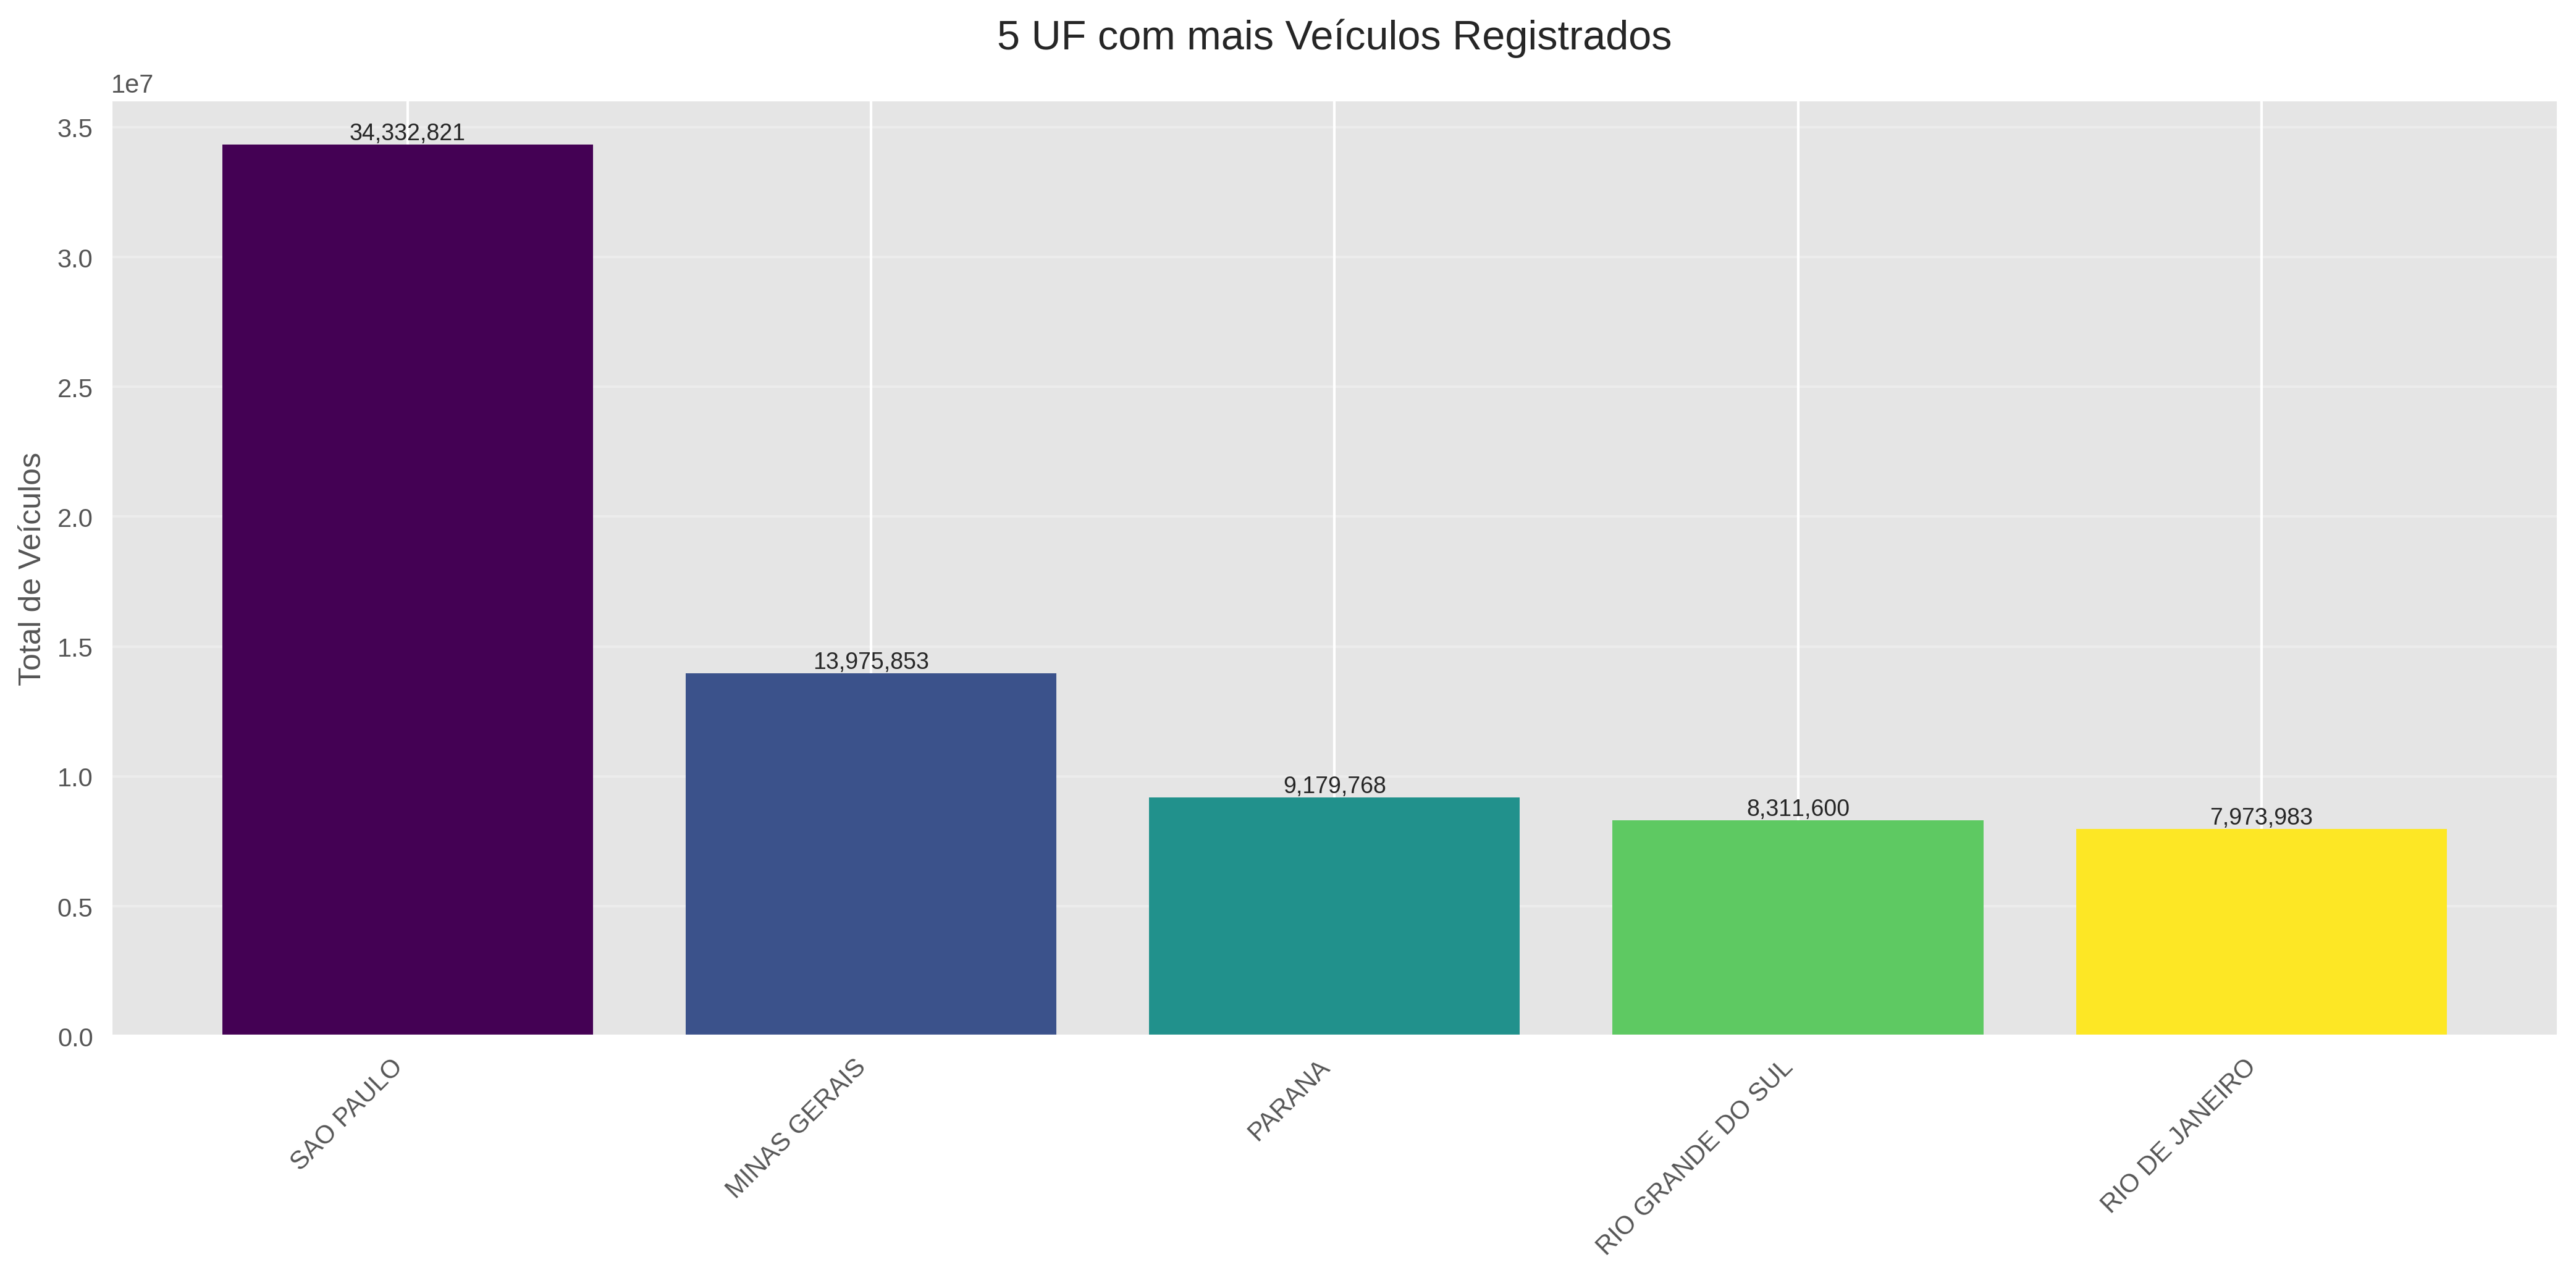

### Evolução Temporal

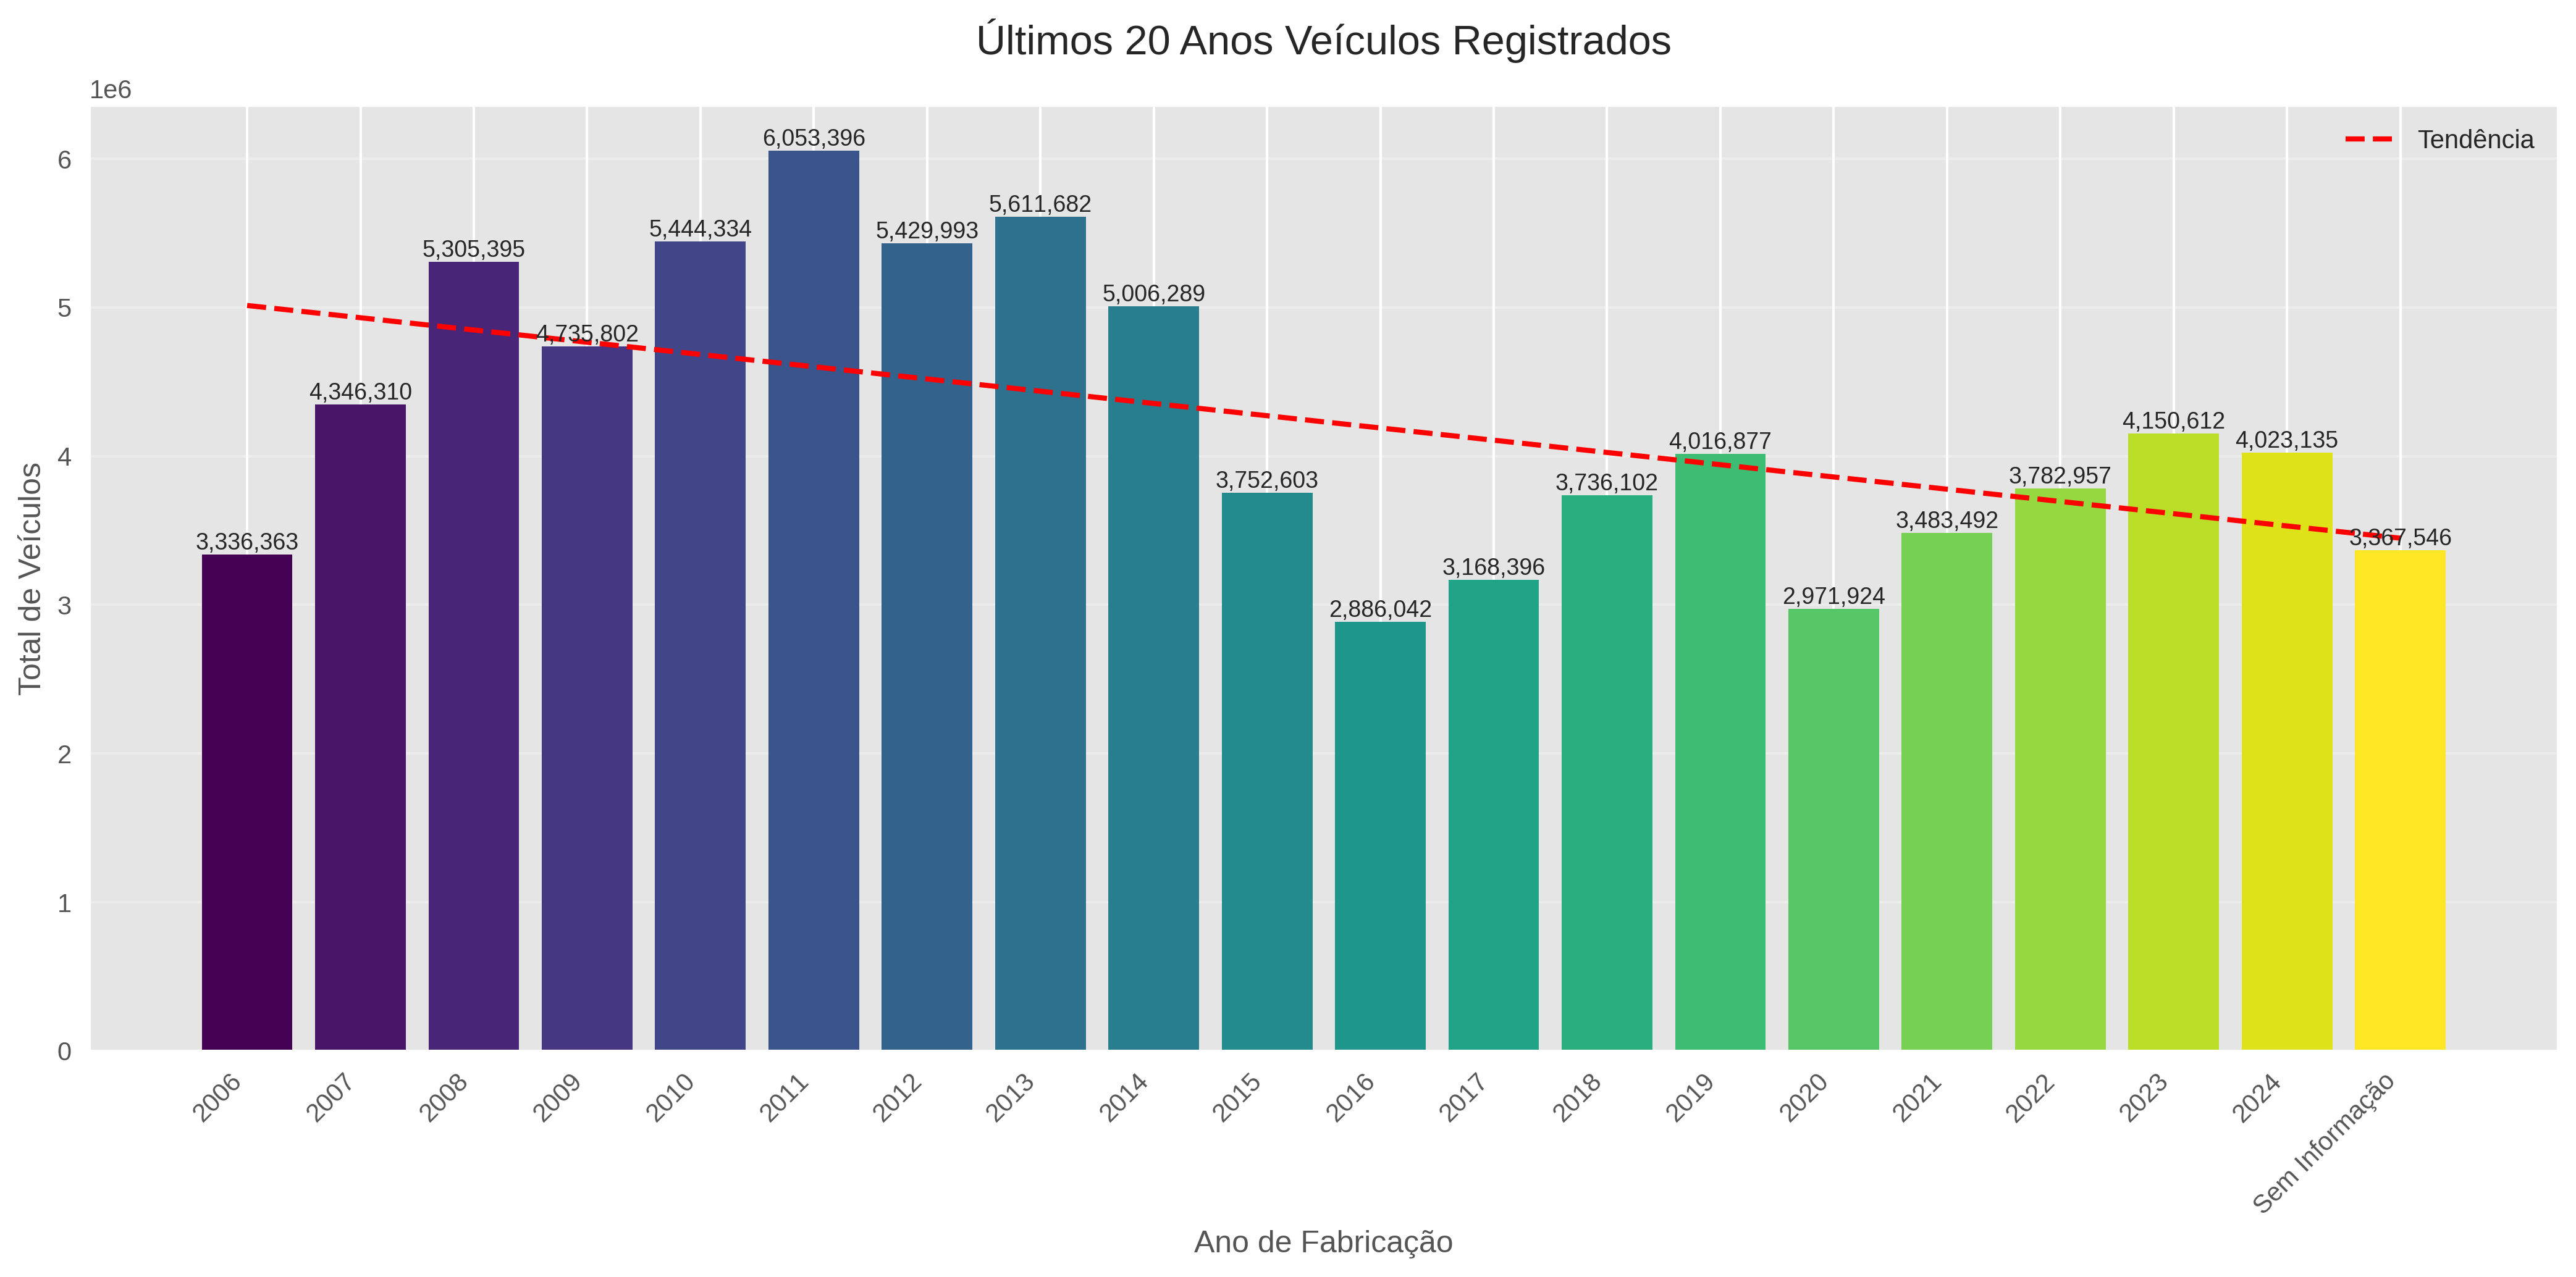

### Análise Detalhada - Sao Paulo

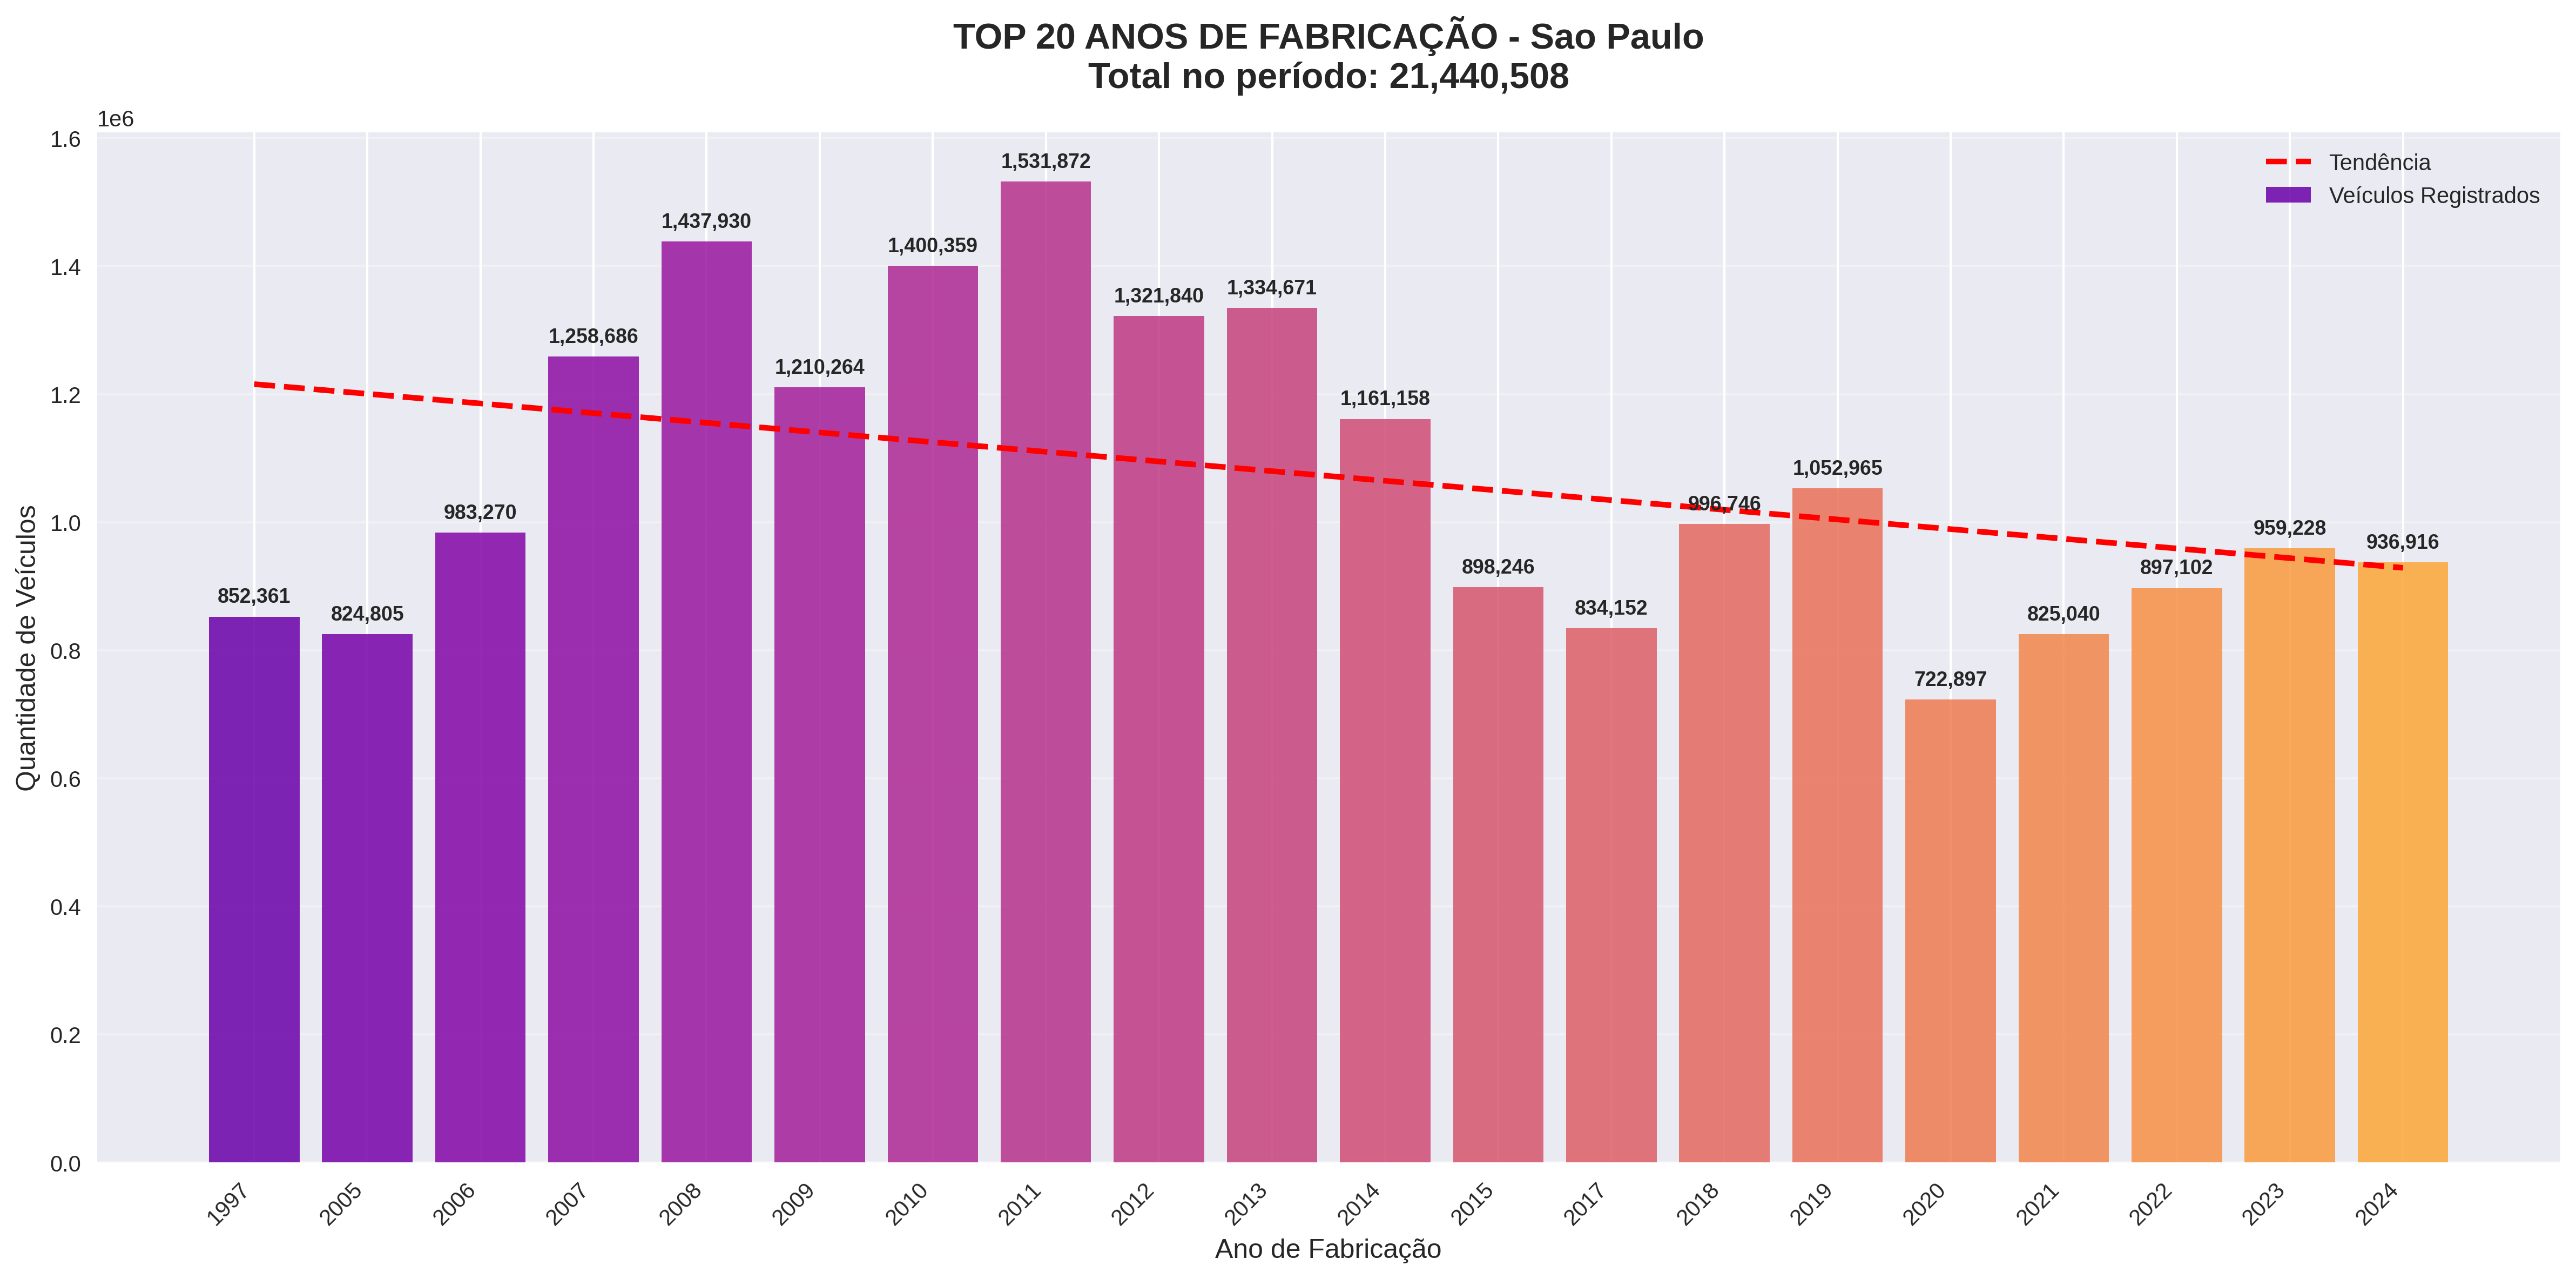

In [25]:
from IPython.display import display, Markdown, Image

# Resumo analítico
display(Markdown("""
# Resumo da Análise

Principais conclusões:
1. Estado com maior frota: **{}**
2. Ano com maior registro: **{}**
3. Tendência geral: {}
""".format(top_5.iloc[0]['UF'],
           df_veiculos_ano.iloc[0]['Ano Fabricação'],
           "Crescente" if p(x)[-1] > p(x)[0] else "Decrescente")))

# Exibir os gráficos um abaixo do outro
display(Markdown("# Visualização dos Dados"))
display(Markdown("### Distribuição por UF"))
display(Image(filename='graficos/top_5_ufs.png'))
display(Markdown("### Evolução Temporal"))
display(Image(filename='graficos/ultimos_20_anos.png'))


if escolha_estado in dfs_por_uf:
    display(Markdown(f"### Análise Detalhada - {escolha_estado.title()}"))
    display(Image(filename=f'graficos/top20_{escolha_estado.lower()}.png'))
